## Analisis de O3 y SO2 arduair vs estacion universidad pontificia bolivariana
Se compararon los resultados generados por el equipo arduair y la estacion de calidad de aire propiedad de la universidad pontificia bolivariana seccional bucaramanga

Cabe resaltar que durante la ejecucion de las pruebas, el se sospechaba equipo de SO2 de la universidad pontificia, por lo cual no se pueden interpretar estos resultados como fiables 

## Library imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import xlrd
%matplotlib inline

pd.options.mode.chained_assignment = None 

## Estudios de correlacion
Se realizaron graficos de correlacion para el ozono y el dioxido de azufre con la estacion de referencia.

Tambien se comparo los datos crudos arrojados por el sensor de ozono, con las ecuaciones de calibracion propuesta por el [datasheet](https://www.terraelectronica.ru/%2Fds%2Fpdf%2FM%2Fmq131-low.pdf), obteniendose mejores resultados con los datos sin procesar.

C:\Users\fega0\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


,raw_so2
datetime,
2017-04-21 19:00:00,-1.744186
2017-04-21 20:00:00,-1.796667
2017-04-21 21:00:00,-1.643333
2017-04-21 22:00:00,-1.581667
2017-04-21 23:00:00,-2.031667


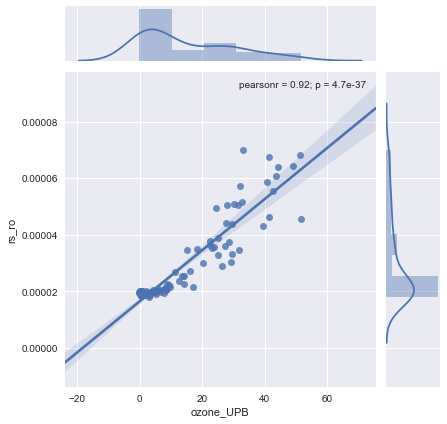

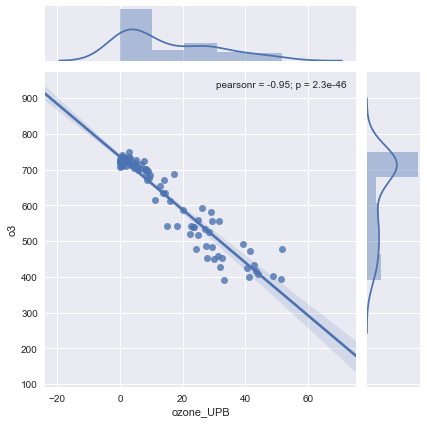

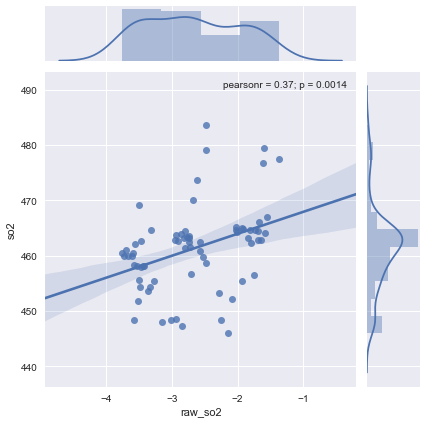

In [3]:
#Arduair prototype data
dfArd=pd.read_csv('DATA.TXT',names=['year','month','day','hour','minute','second','hum','temp','pr','l','co','so2','no2','o3','pm10','pm25','void'])
#Dates to datetime
dates=dfArd[['year','month','day','hour','minute','second']]
dates['year']=dates['year'].add(2000)
dates['minute']=dates['minute'].add(60)
dfArd['datetime']=pd.to_datetime(dates)

#agregation
dfArdo3=dfArd[['datetime','o3']]
dfArdso2=dfArd[['datetime','so2']]

#O3 processing
MQ131_RL= 10 #Load resistance
MQ131_VIN = 5 #Vin
MQ131_RO = 5 #reference resistance
dfArdo3['rs']=((MQ131_VIN/dfArdo3['o3'])/dfArdo3['o3'])*MQ131_RL;
dfArdo3['rs_ro'] = dfArdo3['rs']/MQ131_RO;
dfArdo3['rs_ro_abs']=abs(dfArdo3['rs_ro'])

#station data
dfo3=pd.read_csv('o3_upb.csv')
dfso2=pd.read_csv('so2_upb.csv')
dfso2.tail()
dfso2['datetime']=pd.to_datetime(dfso2['date time'])
dfo3['datetime']=pd.to_datetime(dfo3['date time'])

dfso2=dfso2[['datetime','pump_status']]
dfo3=dfo3[['datetime','pump_status']]

# bad label correction
dfso2.columns = ['datetime', 'raw_so2']
dfo3.columns = ['datetime', 'ozone_UPB']

#grouping
dfArdo3 =dfArdo3 .groupby(pd.Grouper(key='datetime',freq='1h',axis=1)).mean()
dfArdso2=dfArdso2.groupby(pd.Grouper(key='datetime',freq='1h',axis=1)).mean()
dfo3    =dfo3    .groupby(pd.Grouper(key='datetime',freq='1h',axis=1)).mean()
dfso2   =dfso2   .groupby(pd.Grouper(key='datetime',freq='1h',axis=1)).mean()

df2=pd.concat([dfo3,dfArdo3], join='inner', axis=1).reset_index()
df3=pd.concat([dfso2,dfArdso2], join='inner', axis=1).reset_index()
#Ozono calibrado
sns.jointplot(data=df2,x='ozone_UPB',y='rs_ro', kind='reg')
#Ozono crudo
sns.jointplot(data=df2,x='ozone_UPB',y='o3', kind='reg')
#SO2
sns.jointplot(data=df3,x='raw_so2',y='so2', kind='reg')
dfso2.head()

### Defino algunas funciones de ayuda

In [4]:
def polyfitEq(x,y):
    C= np.polyfit(x,y,1)
    m=C[0]
    b=C[1]
    return 'y = x*{} + {}'.format(m,b)
def calibrate(x,y):
    C= np.polyfit(x,y,1)
    m=C[0]
    b=C[1]
    return x*m+b
def rename_labels(obj,unit):
    obj.columns=obj.columns.map(lambda x: x.replace('2',' stc_cdmb'))
    obj.columns=obj.columns.map(lambda x: x+' '+unit)
    return obj.columns

In [5]:
print('')
print('Ozono promedio 1h, sin procesar')
print(polyfitEq(df2['ozone_UPB'],df2['o3']))
#print('')
#print('Promedio 2h')
#print(polyfitEq(df2['pm10'],df2['pm10_dusttrack']))
print('')
print('Promedio 3h')
print(polyfitEq(df3['raw_so2'],df3['so2']))


Ozono promedio 1h, sin procesar
y = x*-7.386462397051218 + 735.7745124254552

Promedio 3h
y = x*3.9667587988316875 + 471.89151081632417


## Datasheets calibrados

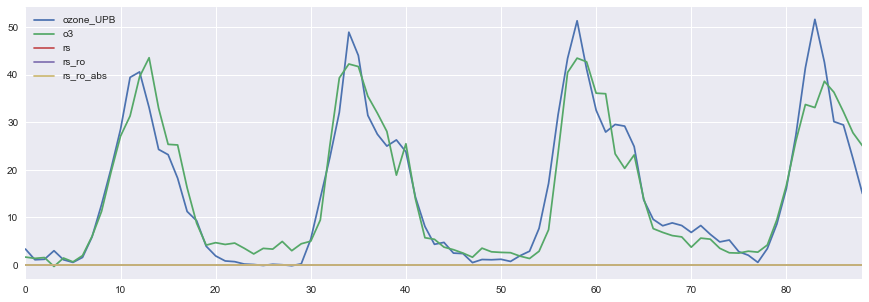

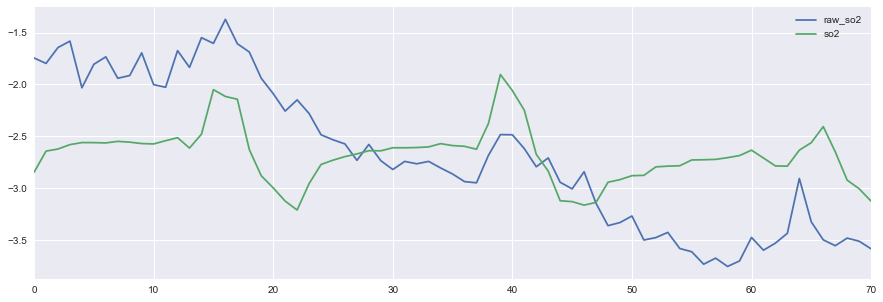

In [6]:
df2['o3']=calibrate(df2['o3'],df2['ozone_UPB'])
df2.plot(figsize=[15,5])

df3['so2']=calibrate(df3['so2'],df3['raw_so2'])
df3.plot(figsize=[15,5])



C:\Users\fega0\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


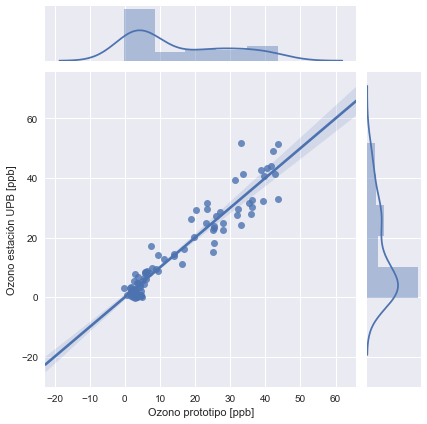

In [7]:
df2.head()
df2.columns = ['datetime', 'Ozono estación UPB [ppb]','Ozono prototipo [ppb]','rs','rs_ro','rs_ro_abs']
sns.jointplot(data=df2,x='Ozono prototipo [ppb]',y='Ozono estación UPB [ppb]', kind='reg',stat_func=None)